In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 5
import seaborn as sns
from datetime import datetime
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
data = pd.read_csv('CourseworkDataResit2024.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.set_index('Date', inplace=True)
data.describe()

,Number of patients
count,1065.000000
mean,45.489202
std,12.622636
min,16.000000
25%,37.000000
50%,44.000000
75%,52.000000
max,97.000000


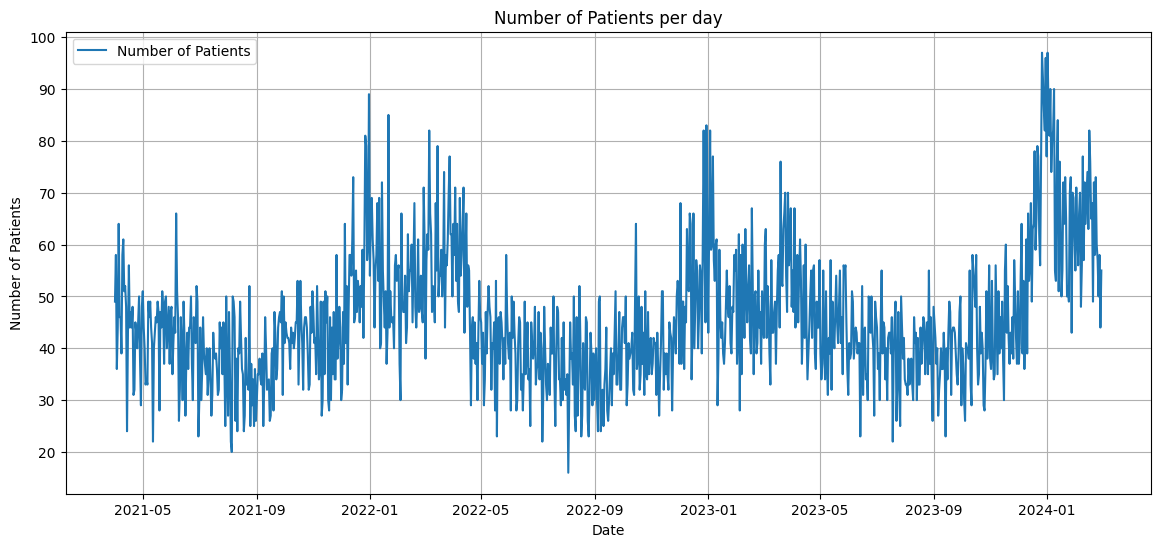

In [ ]:
# Plot time series data
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Number of patients'], label='Number of Patients')
plt.title('Number of Patients per day')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.legend()
plt.grid(True)
plt.show()


{'Total Weeks': 153, 'Total Patients': 48446, 'Minimum Patients in a Week': 187, 'Maximum Patients in a Week': 586}


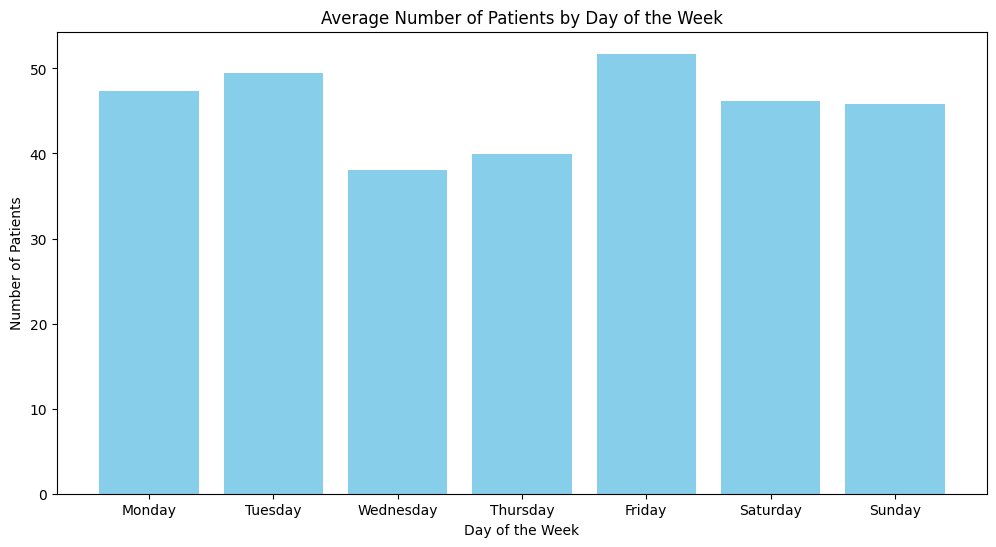

In [ ]:
# Add a column for the day of the week
data['Day of Week'] = data.index.day_name()

# Group by day of the week
day_of_week_data = data.groupby('Day of Week')['Number of patients'].mean()

# Reorder the days of the week for better visualization
day_of_week_data = day_of_week_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# Resample the data to weekly frequency and sum the number of patients per week
weekly_data = data.resample('W').sum()

# Calculate statistics for weekly data
total_weeks = weekly_data.shape[0]
total_patients_weekly = weekly_data['Number of patients'].sum()
min_patients_weekly = weekly_data['Number of patients'].min()
max_patients_weekly = weekly_data['Number of patients'].max()

# Print the weekly statistics
weekly_analysis = {
    "Total Weeks": total_weeks,
    "Total Patients": total_patients_weekly,
    "Minimum Patients in a Week": min_patients_weekly,
    "Maximum Patients in a Week": max_patients_weekly,
}

print(weekly_analysis)

# Plot day of the week trends
plt.figure(figsize=(12, 6))
plt.bar(day_of_week_data.index, day_of_week_data, color='skyblue')
plt.title('Average Number of Patients by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Patients')
plt.show()


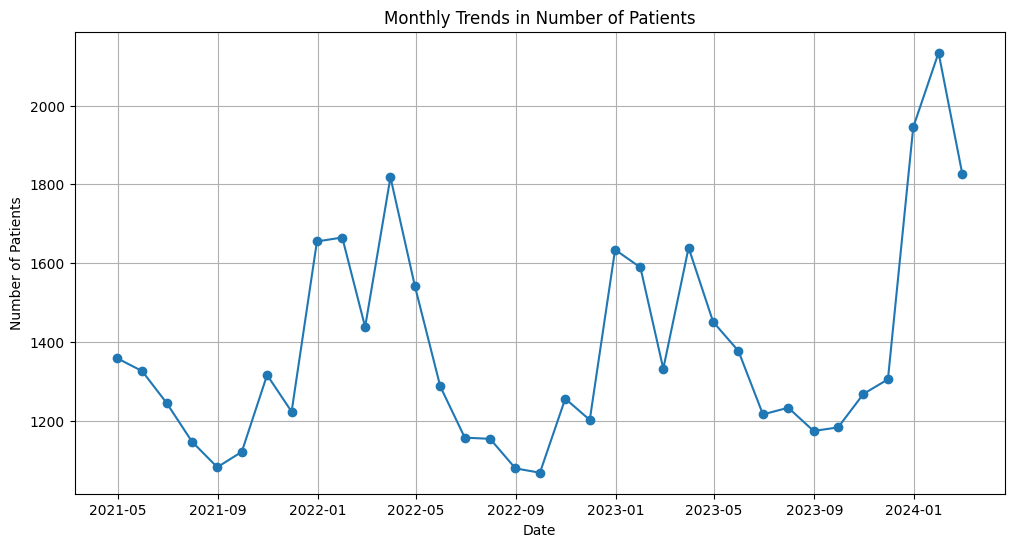

In [ ]:
# Group by month
monthly_data = data['Number of patients'].resample('M').sum()

# Plot monthly trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data, marker='o', linestyle='-')
plt.title('Monthly Trends in Number of Patients')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()


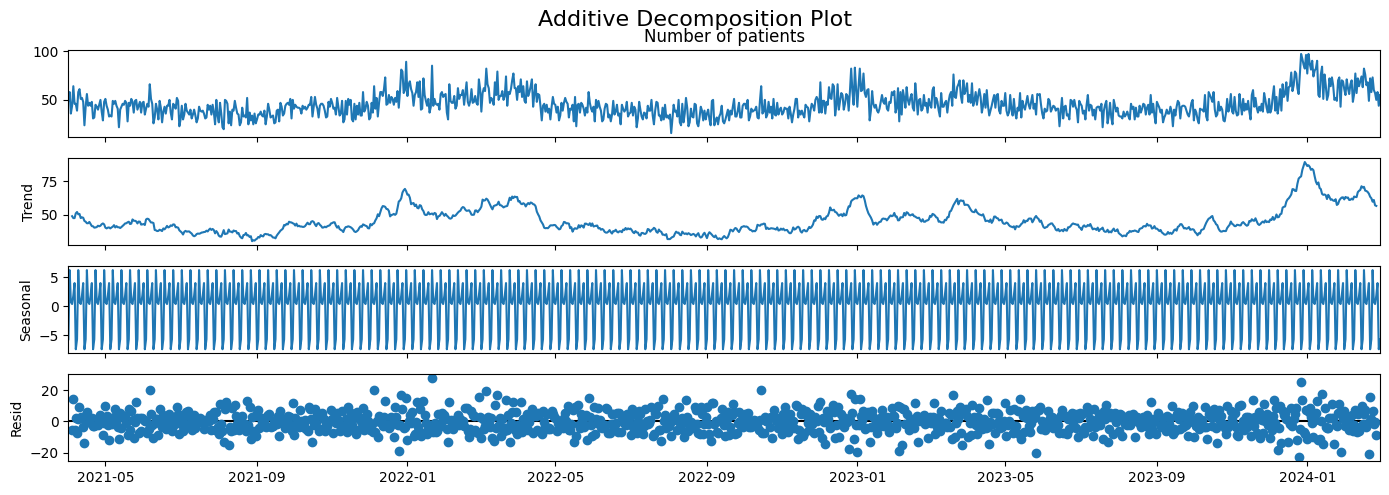

In [ ]:
data = data.asfreq('D')
additive_decompose = seasonal_decompose(data['Number of patients'], model='additive')
fig = additive_decompose.plot()
fig.suptitle('Additive Decomposition Plot', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

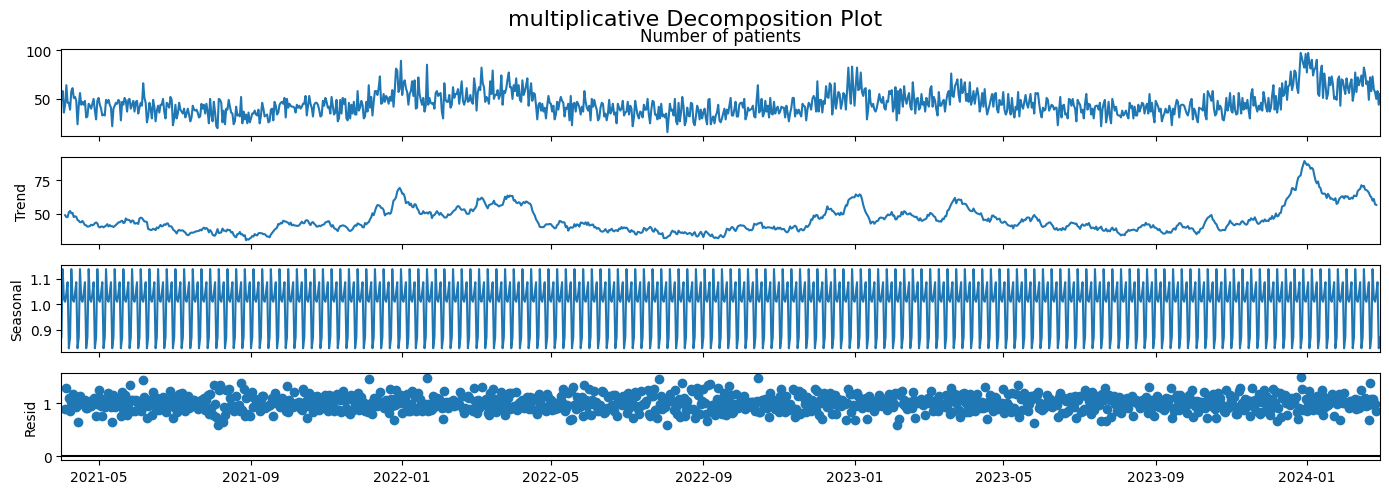

In [ ]:
multiplicative_decompose = seasonal_decompose(data['Number of patients'], model='multiplicative')
fig = multiplicative_decompose.plot()
fig.suptitle('multiplicative Decomposition Plot', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

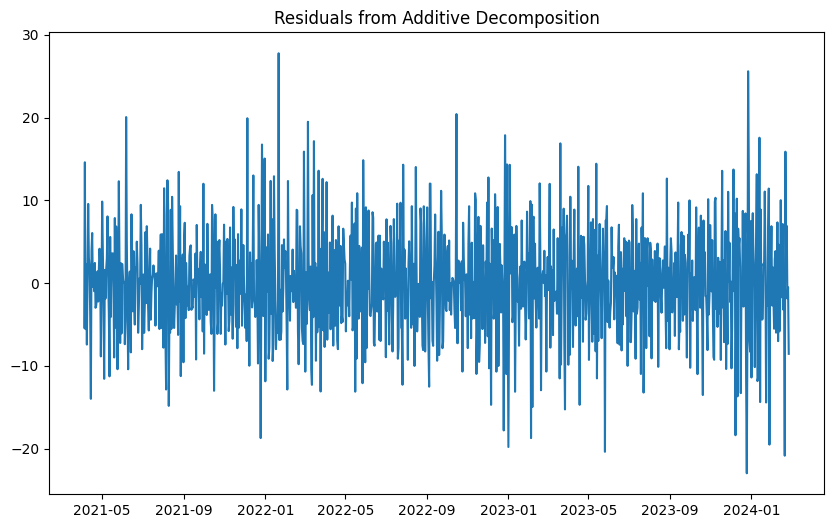

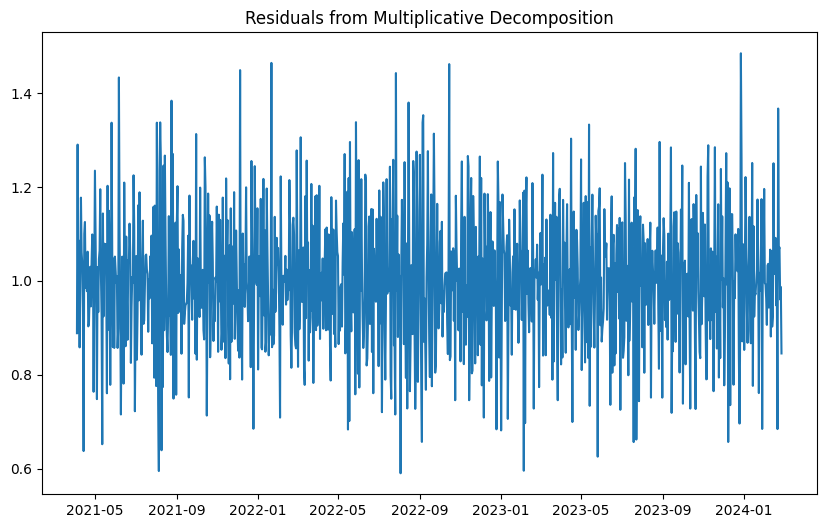

In [ ]:
# Plot residuals from additive decomposition
plt.figure(figsize=(10, 6))
plt.plot(additive_decompose.resid)
plt.title('Residuals from Additive Decomposition')
plt.show()

# Plot residuals from multiplicative decomposition
plt.figure(figsize=(10, 6))
plt.plot(multiplicative_decompose.resid)
plt.title('Residuals from Multiplicative Decomposition')
plt.show()


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

# Load the data
data = pd.read_csv('CourseworkDataResit2024.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.set_index('Date', inplace=True)
data = data.asfreq('D')

# ADF Test to check if the data is stationary
adf_test = adfuller(data['Number of patients'], autolag='AIC')

adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', 'No. of Lags used', 'No. of observations used'])
for key, value in adf_test[4].items():
    adf_output['Critical Value (%s)' % key] = value

print("ADF Test Results:")
print(adf_output)
print('Stationary' if adf_test[1] <= 0.05 else 'Non-Stationary')

# KPSS Test to check if the data is stationary
kpss_test = kpss(data['Number of patients'], regression='c')

kpss_output = pd.Series(kpss_test[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
for key, value in kpss_test[3].items():
    kpss_output['Critical Value (%s)' % key] = value

print("\nKPSS Test Results:")
print(kpss_output)
print('non-Stationary' if kpss_test[1] <= 0.05 else 'Stationary')


ADF Test Results:
Test Statistic                -2.891181
p-value                        0.046383
No. of Lags used              22.000000
No. of observations used    1042.000000
Critical Value (1%)           -3.436641
Critical Value (5%)           -2.864318
Critical Value (10%)          -2.568249
dtype: float64
Stationary

KPSS Test Results:
Test Statistic            0.599963
p-value                   0.022640
Lags Used                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
non-Stationary


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

# First Order Differencing to make the data stationary
data['Differenced_Patients'] = data['Number of patients'].diff()
data_diff = data.dropna()  # Drop NA values created by differencing

# Print the first few rows of the differenced data
print(data_diff.head())

# ADF Test to check if the data after first-order differencing is stationary
df_test_diff = adfuller(data_diff['Differenced_Patients'], autolag='AIC')

dfoutput_diff = pd.Series(df_test_diff[0:4], index=['Test Statistic', 'p-value', 'No. of Lags used', 'No. of observations used'])
for key, value in df_test_diff[4].items():
  dfoutput_diff['Critical Value (%s)' %key] = value

print("ADF Test Results After Differencing:")
print(dfoutput_diff)

# KPSS Test to check if the data after first-order differencing is stationary
kpss_test_diff = kpss(data_diff['Differenced_Patients'], regression='c')

kpss_output_diff = pd.Series(kpss_test_diff[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
for key, value in kpss_test_diff[3].items():
    kpss_output_diff['Critical Value (%s)' %key] = value

print("\nKPSS Test Results After Differencing:")
print(kpss_output_diff)


            Number of patients  Differenced_Patients
Date                                                
2021-04-02                  58                   9.0
2021-04-03                  36                 -22.0
2021-04-04                  44                   8.0
2021-04-05                  64                  20.0
2021-04-06                  46                 -18.0
ADF Test Results After Differencing:
Test Statistic             -7.458545e+00
p-value                     5.430458e-11
No. of Lags used            2.200000e+01
No. of observations used    1.041000e+03
Critical Value (1%)        -3.436647e+00
Critical Value (5%)        -2.864320e+00
Critical Value (10%)       -2.568250e+00
dtype: float64

KPSS Test Results After Differencing:
Test Statistic            0.014187
p-value                   0.100000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype:

<ipython-input-7-3458123550b7>:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_diff = kpss(data_diff['Differenced_Patients'], regression='c')


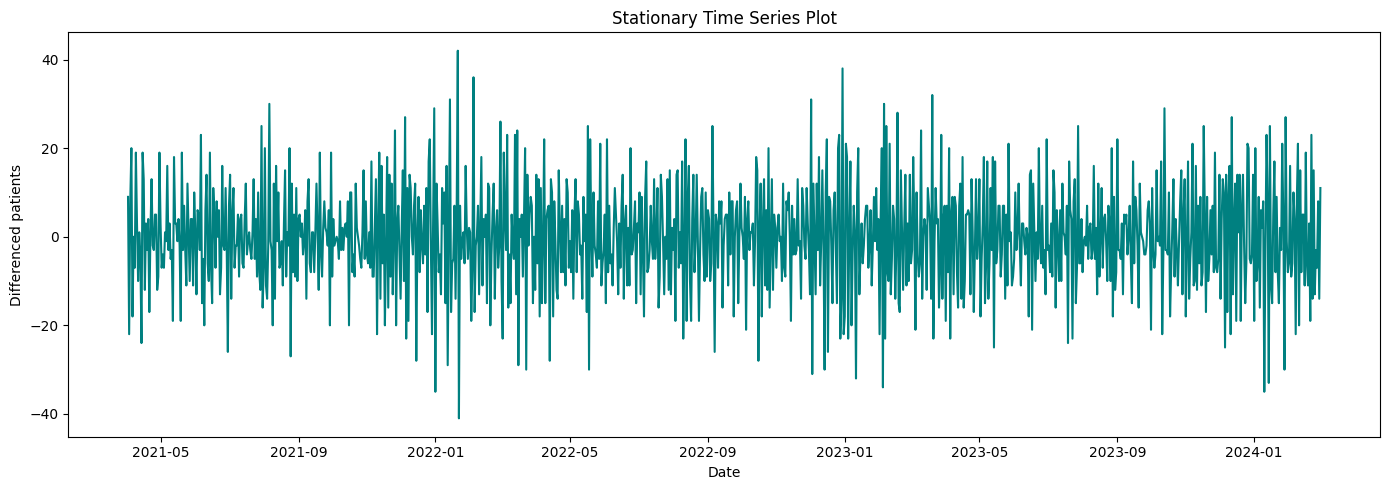

In [ ]:
plt.plot(data_diff['Differenced_Patients'], color='teal')
plt.title('Stationary Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Differenced patients')
plt.tight_layout()
plt.show()

<ipython-input-33-3c0e08741feb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Naive_Forecast'] = naive_forecast


The Error Statistics of the Naive Forecast are:
Mean Error (ME): 8.873239436619718
Mean Absolute Error (MAE): 13.671361502347418
Mean Squared Error (MSE): 346.74178403755866
Root Mean Squared Error (RMSE): 18.621003840758927
Mean Percentage Error (MPE): 9.107937978448078
Mean Absolute Percentage Error (MAPE): 23.999457984995963


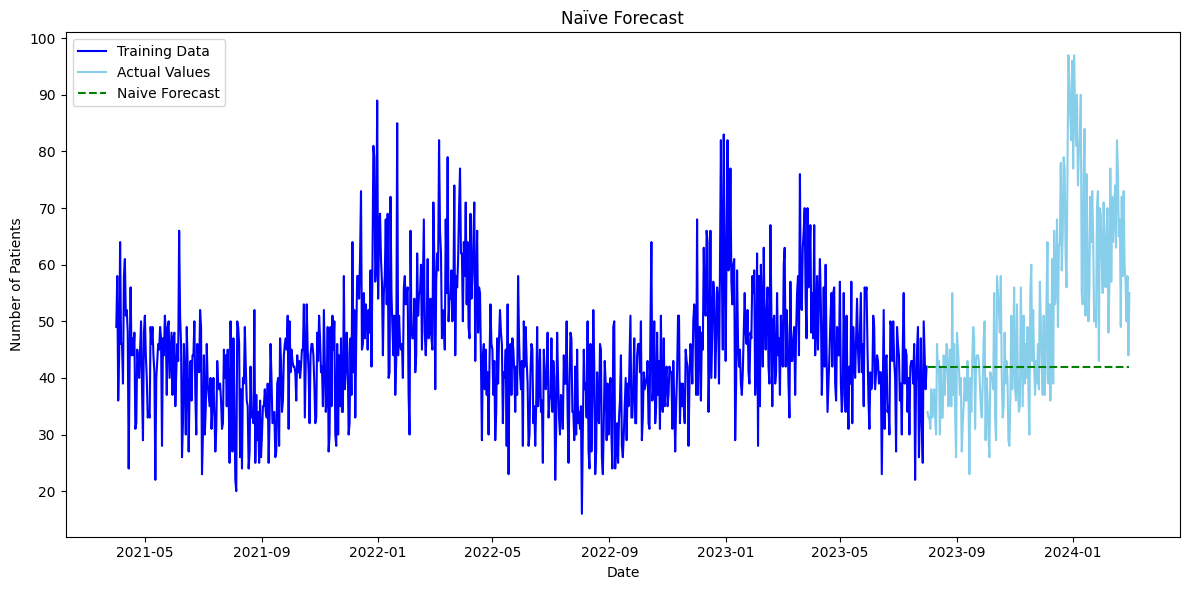

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Train-test split
split_index = round(len(data) * 0.8)
train, test = data.iloc[:split_index], data.iloc[split_index:]

# Naive forecast
naive_forecast = train.iloc[-1]['Number of patients']
test.loc[:, 'Naive_Forecast'] = naive_forecast

# Error statistics
errors = test['Number of patients'] - test['Naive_Forecast']
naive_me = errors.mean()
naive_mae = mean_absolute_error(test['Number of patients'], test['Naive_Forecast'])
naive_mse = mean_squared_error(test['Number of patients'], test['Naive_Forecast'])
naive_rmse = sqrt(mean_squared_error(test['Number of patients'], test['Naive_Forecast']))
naive_mpe = (errors / test['Number of patients']).mean() * 100
naive_mape = (abs(errors) / test['Number of patients']).mean() * 100

print('The Error Statistics of the Naive Forecast are:')
print(f'Mean Error (ME): {naive_me}')
print(f'Mean Absolute Error (MAE): {naive_mae}')
print(f'Mean Squared Error (MSE): {naive_mse}')
print(f'Root Mean Squared Error (RMSE): {naive_rmse}')
print(f'Mean Percentage Error (MPE): {naive_mpe}')
print(f'Mean Absolute Percentage Error (MAPE): {naive_mape}')

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Number of patients'], label='Training Data', color='blue')
plt.plot(test.index, test['Number of patients'], label='Actual Values', color='skyblue')
plt.plot(test.index, test['Naive_Forecast'], label='Naive Forecast', linestyle='--', color='green')

plt.title('Naïve Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


<ipython-input-10-a7ef18007d88>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Moving_Average'] = train['Number of patients'].rolling(window=size_of_window).mean().shift(1)
<ipython-input-10-a7ef18007d88>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Moving_Average_Forecast'] = moving_average_forecast


The Error Statistics of the Moving Average Forecasting Model are:
Mean Error (ME): 12.301810865191156
Mean Absolute Error (MAE): 14.865191146881294
Mean Squared Error (MSE): 419.34195650091027
Root Mean Squared Error (RMSE): 20.477840621044745
Mean Percentage Error (MPE): 16.527698143472726
Mean Absolute Percentage Error (MAPE): 24.908335198547178


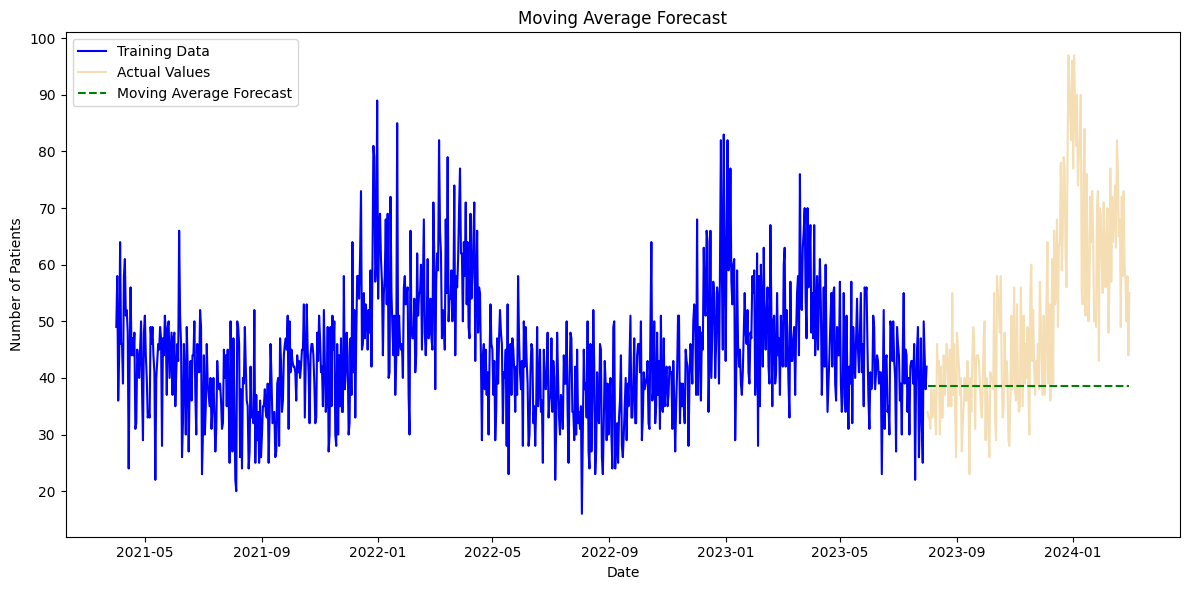

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Train-test split
split_index = round(len(data) * 0.8)
train, test = data.iloc[:split_index], data.iloc[split_index:]

# Calculate Moving Average
size_of_window = 7
train['Moving_Average'] = train['Number of patients'].rolling(window=size_of_window).mean().shift(1)

# Get the last value of moving average for forecasting
moving_average_forecast = train['Moving_Average'].iloc[-1]
test['Moving_Average_Forecast'] = moving_average_forecast

# Error statistics
errors = test['Number of patients'] - test['Moving_Average_Forecast']
moving_average_me = errors.mean()
moving_average_mae = mean_absolute_error(test['Number of patients'], test['Moving_Average_Forecast'])
moving_average_mse = mean_squared_error(test['Number of patients'], test['Moving_Average_Forecast'])
moving_average_rmse = sqrt(moving_average_mse)
moving_average_mpe = (errors / test['Number of patients']).mean() * 100
moving_average_mape = (abs(errors) / test['Number of patients']).mean() * 100
moving_average_aci = (moving_average_mae / moving_average_me) * 100

print('The Error Statistics of the Moving Average Forecasting Model are:')
print(f'Mean Error (ME): {moving_average_me}')
print(f'Mean Absolute Error (MAE): {moving_average_mae}')
print(f'Mean Squared Error (MSE): {moving_average_mse}')
print(f'Root Mean Squared Error (RMSE): {moving_average_rmse}')
print(f'Mean Percentage Error (MPE): {moving_average_mpe}')
print(f'Mean Absolute Percentage Error (MAPE): {moving_average_mape}')

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Number of patients'], label='Training Data', color='blue')
plt.plot(test.index, test['Number of patients'], label='Actual Values', color='wheat')
plt.plot(test.index, test['Moving_Average_Forecast'], label='Moving Average Forecast', linestyle='--', color='green')

plt.title('Moving Average Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


<ipython-input-34-726860ffd60b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['TimeIndex'] = np.arange(len(train))
<ipython-input-34-726860ffd60b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['TimeIndex'] = np.arange(len(train), len(train) + len(test))


The Error Statistics of the Linear Regression Model are:
Mean Error (ME): 4.948507266057656
Mean Absolute Error (MAE): 13.021002465458265
Mean Squared Error (MSE): 287.89866682403107
Root Mean Squared Error (RMSE): 16.967576928484252
Mean Percentage Error (MPE): 16.527698143472726
Mean Absolute Percentage Error (MAPE): 24.69678610876534%
AIC: 0.005508588033552697
BIC: 0.005508588033552697


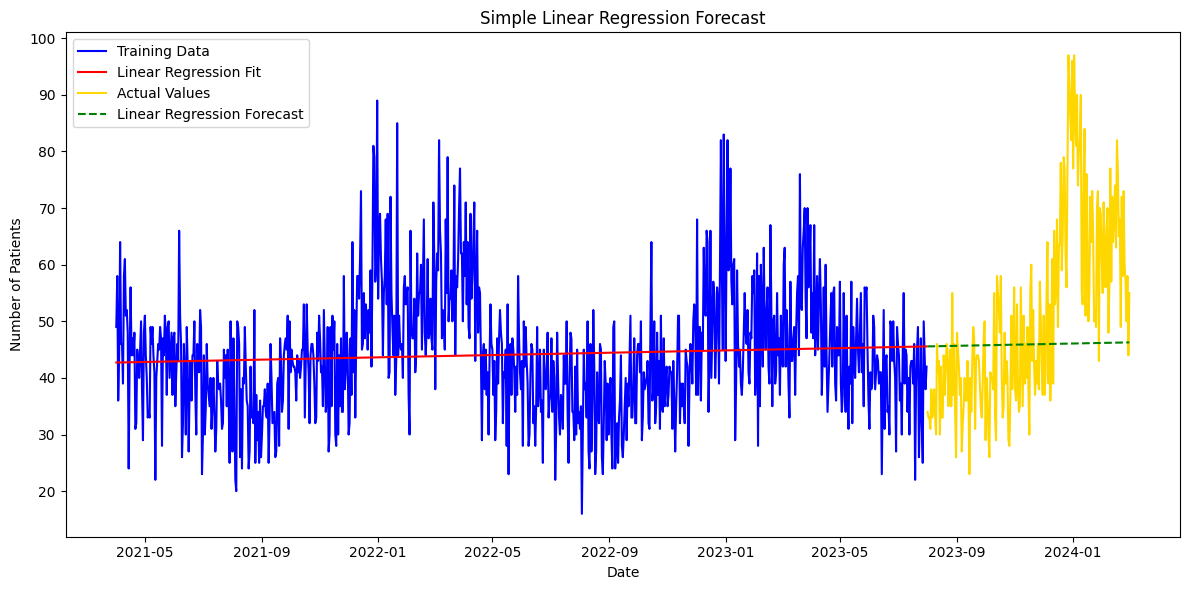

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Add TimeIndex to the datasets
train['TimeIndex'] = np.arange(len(train))
test['TimeIndex'] = np.arange(len(train), len(train) + len(test))

# Prepare the data for regression model
X_train = train['TimeIndex'].values.reshape(-1, 1)
y_train = train['Number of patients'].values
X_test = test['TimeIndex'].values.reshape(-1, 1)

# Fit the Linear Regression model
model = LinearRegression().fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate error statistics
lr_me = (test['Number of patients'] - y_pred_test).mean()
lr_mae = mean_absolute_error(test['Number of patients'], y_pred_test)
lr_mse = mean_squared_error(test['Number of patients'], y_pred_test)
lr_rmse = np.sqrt(lr_mse)
lr_mpe = (errors / test['Number of patients']).mean() * 100
lr_mape = np.mean(np.abs((test['Number of patients'] - y_pred_test) / test['Number of patients'])) * 100
lr_aic = model.score(X_train, y_train)
lr_bic = model.score(X_train, y_train)
print('The Error Statistics of the Linear Regression Model are:')
print(f'Mean Error (ME): {lr_me}')
print(f'Mean Absolute Error (MAE): {lr_mae}')
print(f'Mean Squared Error (MSE): {lr_mse}')
print(f'Root Mean Squared Error (RMSE): {lr_rmse}')
print(f'Mean Percentage Error (MPE): {moving_average_mpe}')
print(f'Mean Absolute Percentage Error (MAPE): {lr_mape}%')
print(f'AIC: {lr_aic}')
print(f'BIC: {lr_bic}')
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Number of patients'], label='Training Data', color='blue')
plt.plot(train.index, y_pred_train, label='Linear Regression Fit', color='red')
plt.plot(test.index, test['Number of patients'], label='Actual Values', color='gold')
plt.plot(test.index, y_pred_test, label='Linear Regression Forecast', color='green', linestyle='--')

plt.title('Simple Linear Regression Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


The Error Statistics of the Single Exponential Smoothing Model are:
Mean Error (ME): 11.501160618410223
Mean Absolute Error (MAE): 14.513489673484472
Mean Squared Error (MSE): 400.2841015084455
Root Mean Squared Error (RMSE): 20.00710127700776
Mean Percentage Error (MPE): 16.527698143472726
Mean Absolute Percentage Error (MAPE): 24.51275751298577%
AIC: 3762.334051522739
BIC: 3771.829224576398


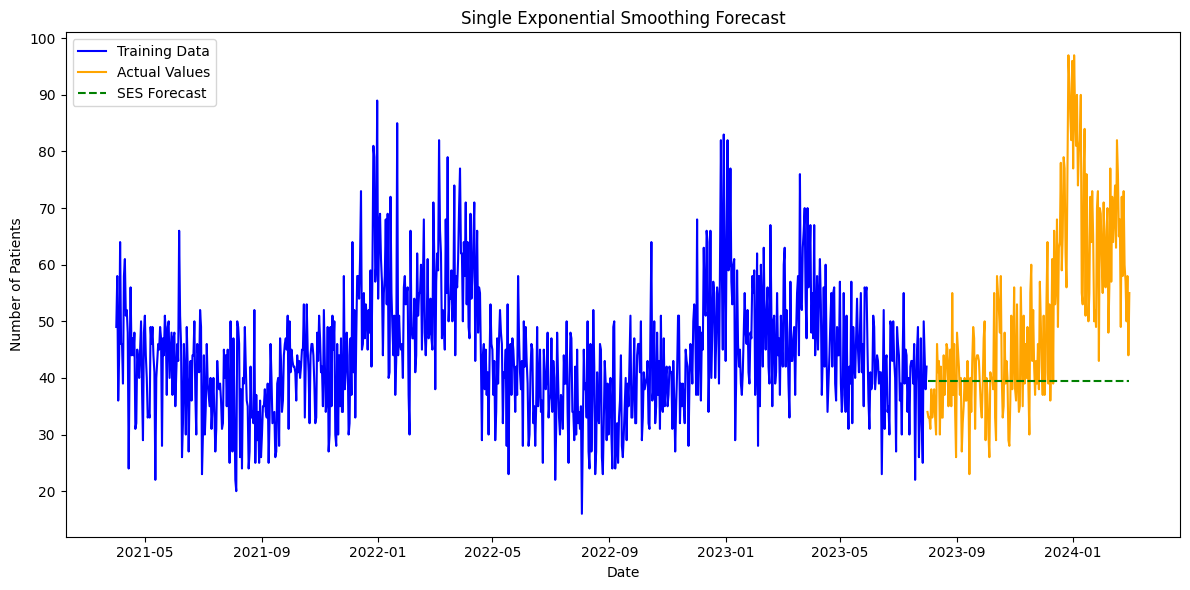

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import matplotlib.pyplot as plt
import numpy as np

# Fit Single Exponential Smoothing model
ses_model = SimpleExpSmoothing(train['Number of patients']).fit()
ses_predictions = ses_model.forecast(len(test))

# Calculate error statistics
ses_me = (test['Number of patients'] - ses_predictions).mean()
ses_mae = mean_absolute_error(test['Number of patients'], ses_predictions)
ses_mse = mean_squared_error(test['Number of patients'], ses_predictions)
ses_rmse = np.sqrt(ses_mse)
ses_mpe = (errors / test['Number of patients']).mean() * 100
ses_mape = np.mean(np.abs((test['Number of patients'] - ses_predictions) / test['Number of patients'])) * 100
ses_aic = ses_model.aic
ses_bic = ses_model.bic
print('The Error Statistics of the Single Exponential Smoothing Model are:')
print(f'Mean Error (ME): {ses_me}')
print(f'Mean Absolute Error (MAE): {ses_mae}')
print(f'Mean Squared Error (MSE): {ses_mse}')
print(f'Root Mean Squared Error (RMSE): {ses_rmse}')
print(f'Mean Percentage Error (MPE): {moving_average_mpe}')
print(f'Mean Absolute Percentage Error (MAPE): {ses_mape}%')
print(f'AIC: {ses_aic}')
print(f'BIC: {ses_bic}')
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Number of patients'], label='Training Data', color='blue')
plt.plot(test.index, test['Number of patients'], label='Actual Values', color='orange')
plt.plot(test.index, ses_predictions, label='SES Forecast', linestyle='--', color='green')

plt.title('Single Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


The Error Statistics of the Holt's Linear Exponential Smoothing Model are:
Mean Error (ME): 12.702303476192379
Mean Absolute Error (MAE): 15.342858795466572
Mean Squared Error (MSE): 444.38277900831037
Root Mean Squared Error (RMSE): 21.080388492822195
Mean Percentage Error (MPE): 16.527698143472726
Mean Absolute Percentage Error (MAPE): 25.72204012662331%
AIC: 3766.2292042784816
BIC: 3785.219550385799


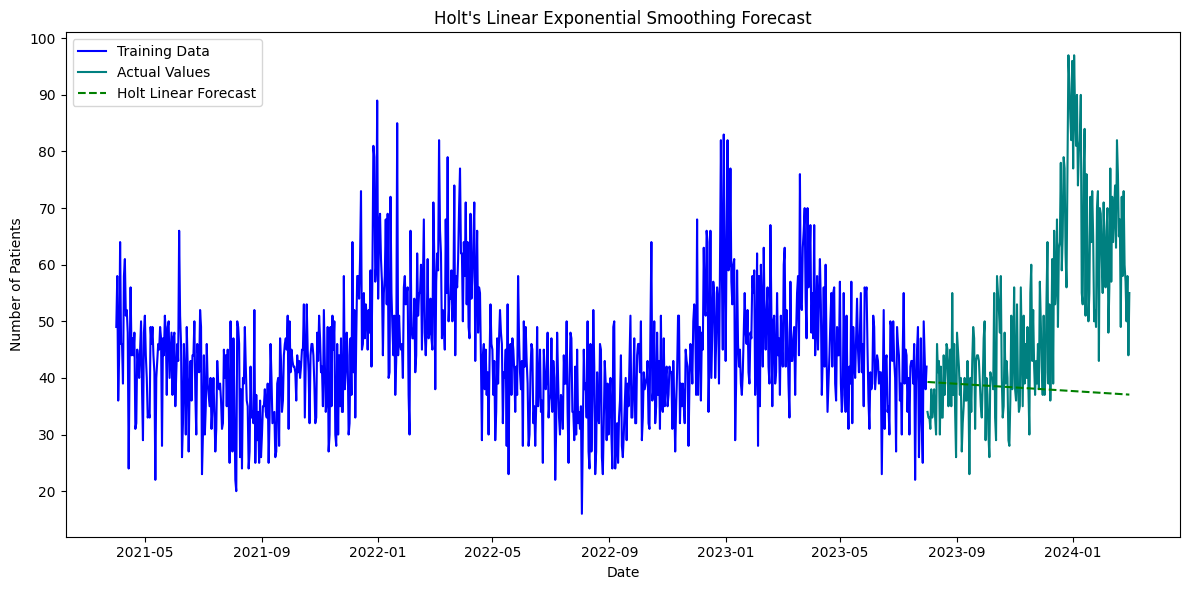

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import numpy as np


# Fit Holt's Linear Exponential Smoothing model
holt_model = ExponentialSmoothing(train['Number of patients'], trend='add').fit()
holt_predictions = holt_model.forecast(len(test))

# Calculate error statistics
holt_me = (test['Number of patients'] - holt_predictions).mean()
holt_mae = mean_absolute_error(test['Number of patients'], holt_predictions)
holt_mse = mean_squared_error(test['Number of patients'], holt_predictions)
holt_rmse = np.sqrt(holt_mse)
holt_mpe = (errors / test['Number of patients']).mean() * 100
holt_mape = np.mean(np.abs((test['Number of patients'] - holt_predictions) / test['Number of patients'])) * 100
holt_aic = holt_model.aic
holt_bic = holt_model.bic
print("The Error Statistics of the Holt's Linear Exponential Smoothing Model are:")
print(f'Mean Error (ME): {holt_me}')
print(f'Mean Absolute Error (MAE): {holt_mae}')
print(f'Mean Squared Error (MSE): {holt_mse}')
print(f'Root Mean Squared Error (RMSE): {holt_rmse}')
print(f'Mean Percentage Error (MPE): {moving_average_mpe}')
print(f'Mean Absolute Percentage Error (MAPE): {holt_mape}%')
print(f'AIC: {holt_aic}')
print(f'BIC: {holt_bic}')
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Number of patients'], label='Training Data', color='blue')
plt.plot(test.index, test['Number of patients'], label='Actual Values', color='teal')
plt.plot(test.index, holt_predictions, label='Holt Linear Forecast', linestyle='--', color='green')

plt.title("Holt's Linear Exponential Smoothing Forecast")
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


The Error Statistics of the Holt-Winters Seasonal Forecast Model are:
Mean Error (ME): 5.088436149822289
Mean Absolute Error (MAE): 10.431184132023537
Mean Squared Error (MSE): 179.40287516485486
Root Mean Squared Error (RMSE): 13.394135849873065
Mean Percentage Error (MPE): 16.527698143472726
Mean Absolute Percentage Error (MAPE): 19.99091865653348%
AIC: 3915.131202195522
BIC: 5666.990630595539


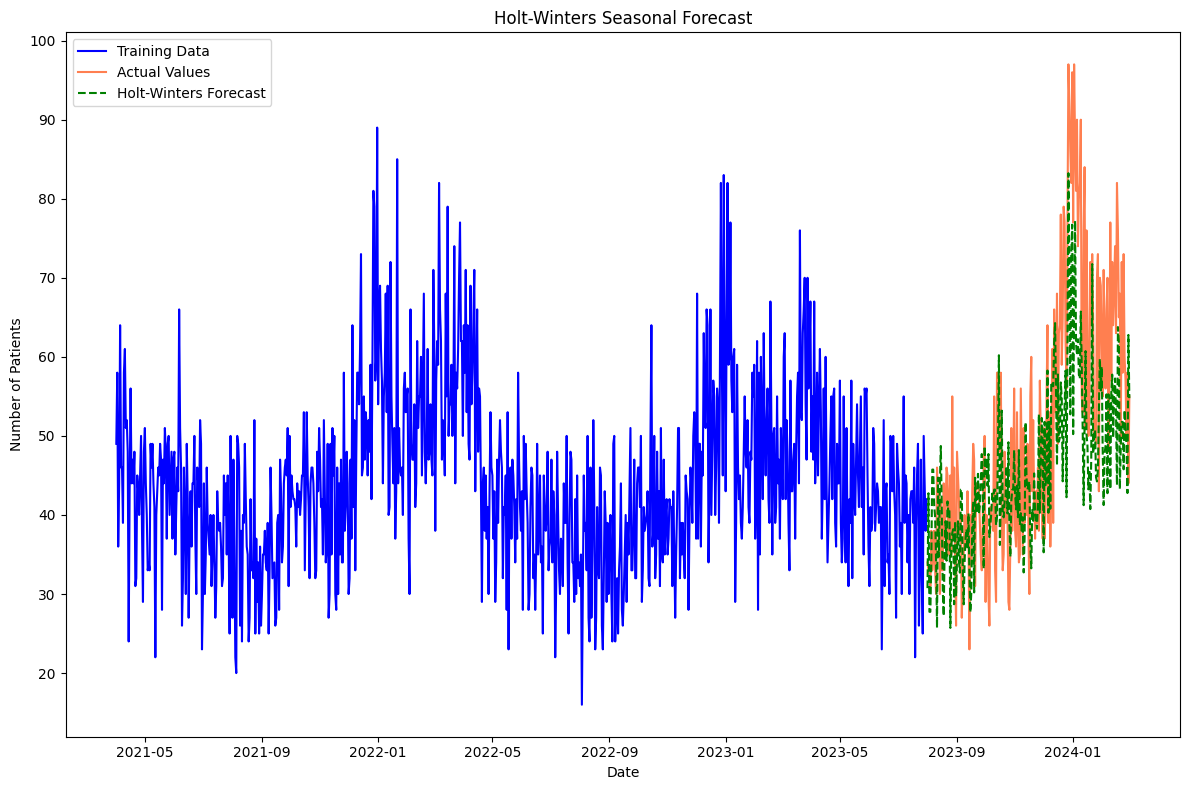

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import numpy as np

# Fit Holt-Winters Seasonal model
hw_model = ExponentialSmoothing(train['Number of patients'], trend='add', seasonal='add', seasonal_periods=365).fit()
hw_predictions = hw_model.forecast(len(test))

# Calculate error statistics
hw_me = (test['Number of patients'] - hw_predictions).mean()
hw_mae = mean_absolute_error(test['Number of patients'], hw_predictions)
hw_mse = mean_squared_error(test['Number of patients'], hw_predictions)
hw_rmse = np.sqrt(hw_mse)
hw_mpe = (errors / test['Number of patients']).mean() * 100
hw_mape = np.mean(np.abs((test['Number of patients'] - hw_predictions) / test['Number of patients'])) * 100
hw_aic = hw_model.aic
hw_bic = hw_model.bic

print("The Error Statistics of the Holt-Winters Seasonal Forecast Model are:")
print(f'Mean Error (ME): {hw_me}')
print(f'Mean Absolute Error (MAE): {hw_mae}')
print(f'Mean Squared Error (MSE): {hw_mse}')
print(f'Root Mean Squared Error (RMSE): {hw_rmse}')
print(f'Mean Percentage Error (MPE): {moving_average_mpe}')
print(f'Mean Absolute Percentage Error (MAPE): {hw_mape}%')
print(f'AIC: {hw_aic}')
print(f'BIC: {hw_bic}')
# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(train.index, train['Number of patients'], label='Training Data', color='blue')
plt.plot(test.index, test['Number of patients'], label='Actual Values', color='coral')
plt.plot(test.index, hw_predictions, label='Holt-Winters Forecast', linestyle='--', color='green')

plt.title('Holt-Winters Seasonal Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


The Error Statistics of the Holt-Winters Seasonal Forecast Model are:
Mean Error (ME): nan
Mean Absolute Error (MAE): 19.233517605693628
Mean Squared Error (MSE): 530.9354545895461
Root Mean Squared Error (RMSE): 23.04203668492753
Mean Percentage Error (MPE): 16.527698143472726
Mean Absolute Percentage Error (MAPE): nan%
AIC: 5363.9754994259765
BIC: 7198.174898260937


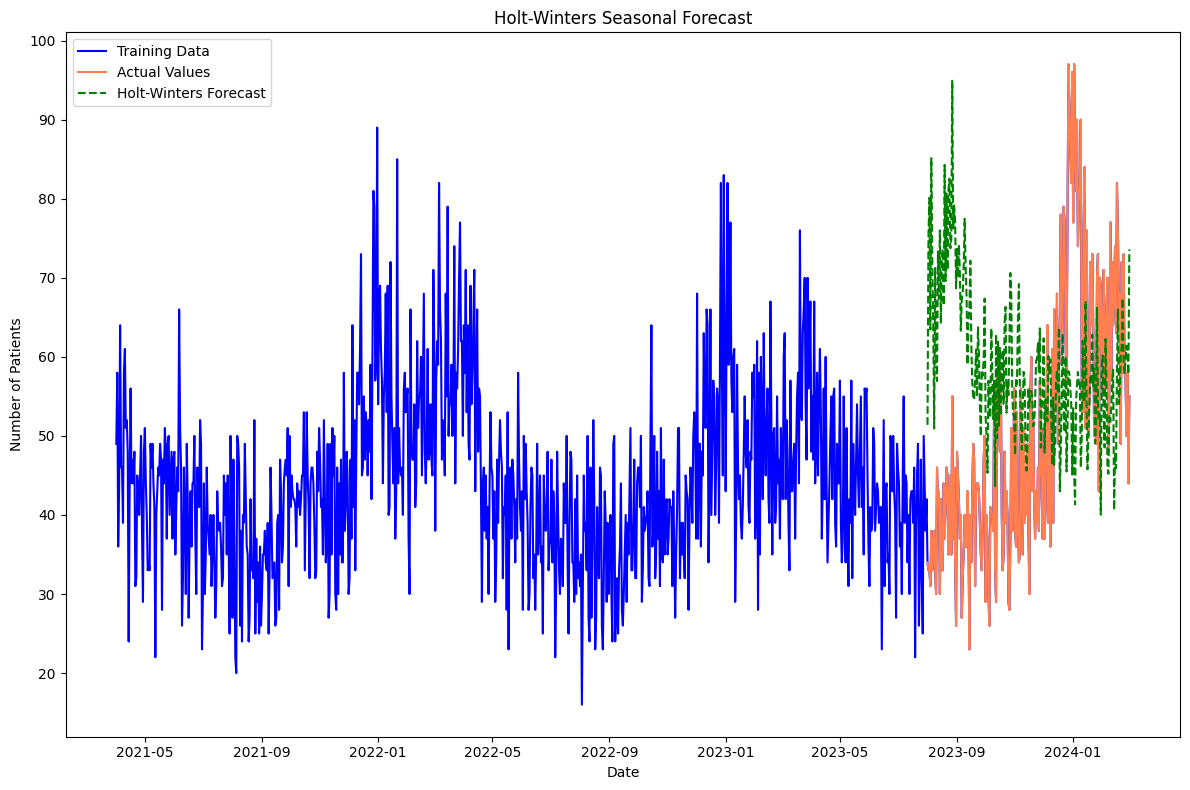

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import numpy as np

# Fit Holt-Winters Seasonal model
hw_model = ExponentialSmoothing(train['Number of patients'], trend='mul', seasonal='mul', seasonal_periods=365).fit()
hw_predictions = hw_model.forecast(len(test))

# Calculate error statistics
hw_me = (test['Number of patients'] - hw_predictions).mean()
hw_mae = mean_absolute_error(test['Number of patients'], hw_predictions)
hw_mse = mean_squared_error(test['Number of patients'], hw_predictions)
hw_rmse = np.sqrt(hw_mse)
hw_mpe = (errors / test['Number of patients']).mean() * 100
hw_mape = np.mean(np.abs((test['Number of patients'] - hw_predictions) / test['Number of patients'])) * 100
hw_aic = hw_model.aic
hw_bic = hw_model.bic

print("The Error Statistics of the Holt-Winters Seasonal Forecast Model are:")
print(f'Mean Error (ME): {hw_me}')
print(f'Mean Absolute Error (MAE): {hw_mae}')
print(f'Mean Squared Error (MSE): {hw_mse}')
print(f'Root Mean Squared Error (RMSE): {hw_rmse}')
print(f'Mean Percentage Error (MPE): {moving_average_mpe}')
print(f'Mean Absolute Percentage Error (MAPE): {hw_mape}%')
print(f'AIC: {hw_aic}')
print(f'BIC: {hw_bic}')
# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(train.index, train['Number of patients'], label='Training Data', color='blue')
plt.plot(test.index, test['Number of patients'], label='Actual Values', color='coral')
plt.plot(test.index, hw_predictions, label='Holt-Winters Forecast', linestyle='--', color='green')

plt.title('Holt-Winters Seasonal Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


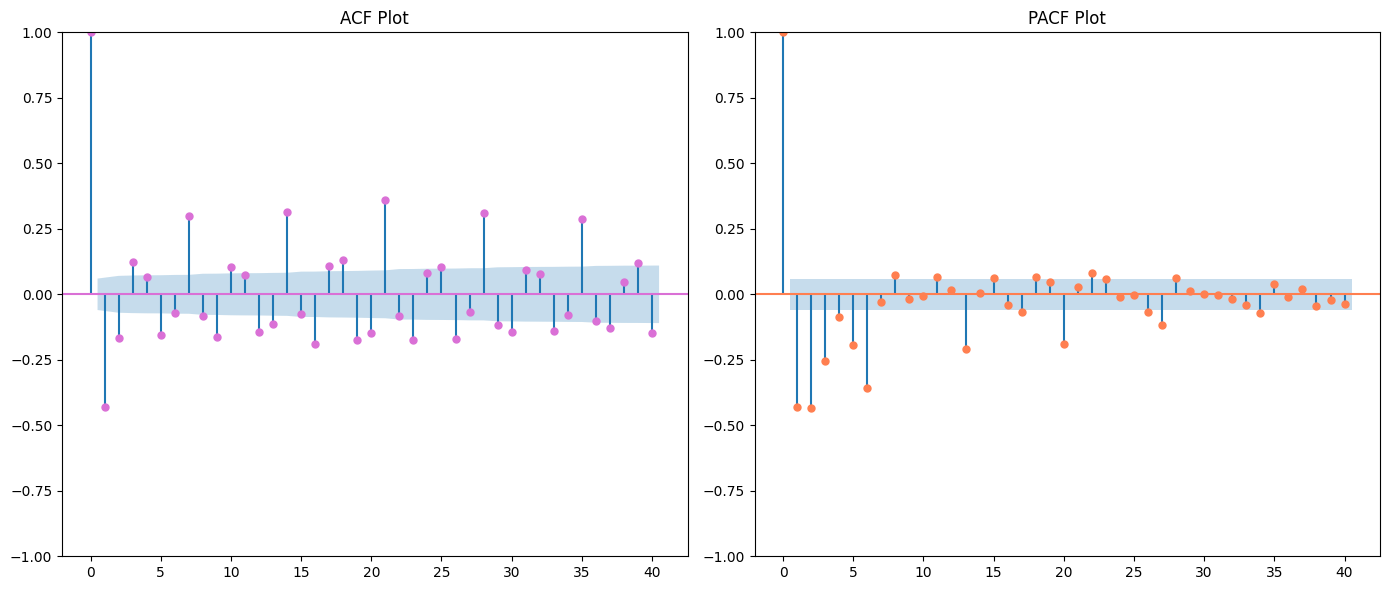

In [ ]:
# Plot ACF and PACF
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(data_diff['Differenced_Patients'], lags=40, ax=plt.gca(), color='orchid')
plt.title('ACF Plot')

plt.subplot(1, 2, 2)
plot_pacf(data_diff['Differenced_Patients'], lags=40, ax=plt.gca(), color='coral')
plt.title('PACF Plot')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The Error Statistics of the ARIMA Forecast Model are:
Mean Error (ME): 11.747390697946622
Mean Absolute Error (MAE): 14.271788978471374
Mean Squared Error (MSE): 393.48551975701594
Root Mean Squared Error (RMSE): 19.836469437806112
Mean Absolute Percentage Error (MAPE) for ARIMA: 23.797164236872614%
AIC: 5943.867301093656
BIC: 6010.317070893683


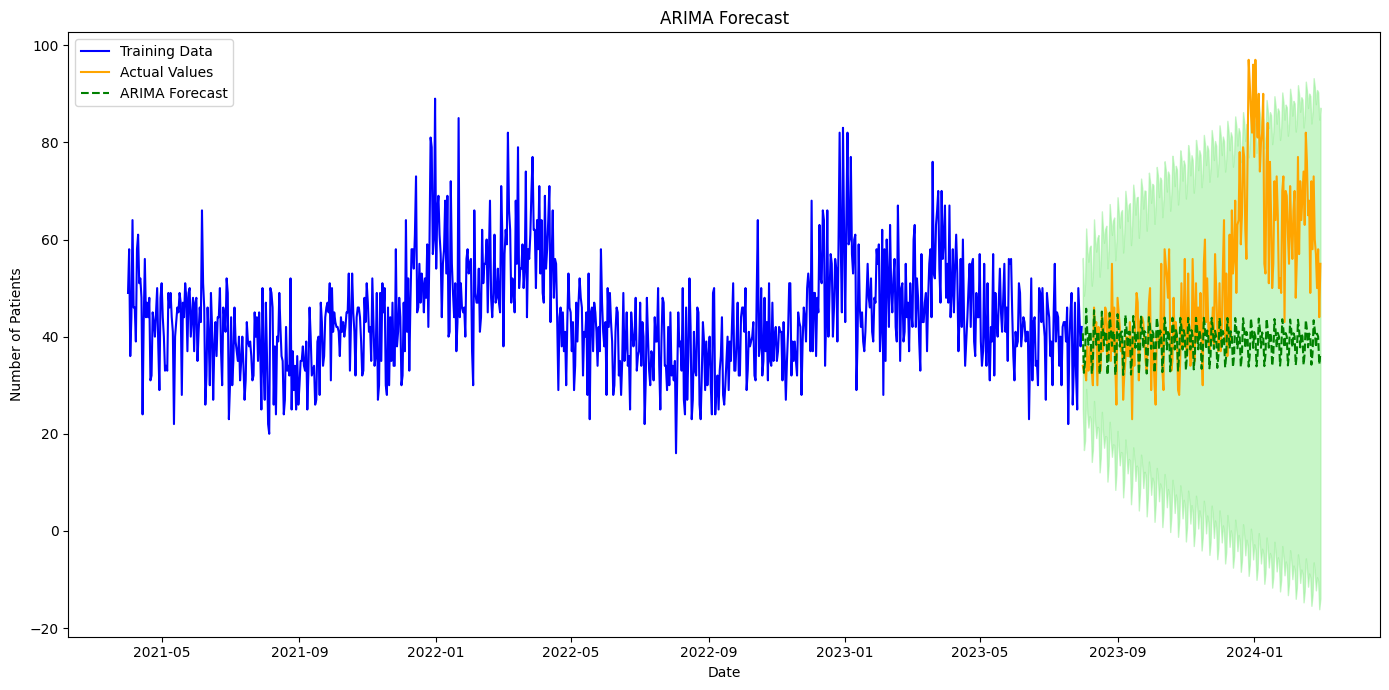

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_order = (6, 1, 7)
arima_model = ARIMA(train['Number of patients'], order=arima_order)
arima_model_fit = arima_model.fit()

# Forecasting
arima_forecast = arima_model_fit.get_forecast(steps=len(test))
forecast_index = test.index
forecast_mean = arima_forecast.predicted_mean
forecast_ci = arima_forecast.conf_int()

# Error statistics
arima_me = (test['Number of patients'] - forecast_mean).mean()
arima_mae = mean_absolute_error(test['Number of patients'], forecast_mean)
arima_mse = mean_squared_error(test['Number of patients'], forecast_mean)
arima_rmse = arima_mse**0.5
arima_mape = np.mean(np.abs((test['Number of patients'] - forecast_mean) / test['Number of patients'])) * 100
arima_aic = arima_model_fit.aic
arima_bic = arima_model_fit.bic

print('The Error Statistics of the ARIMA Forecast Model are:')
print(f'Mean Error (ME): {arima_me}')
print(f'Mean Absolute Error (MAE): {arima_mae}')
print(f'Mean Squared Error (MSE): {arima_mse}')
print(f'Root Mean Squared Error (RMSE): {arima_rmse}')
print(f'Mean Absolute Percentage Error (MAPE) for ARIMA: {arima_mape}%')
print(f'AIC: {arima_aic}')
print(f'BIC: {arima_bic}')

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Number of patients'], label='Training Data', color='blue')
plt.plot(forecast_index, test['Number of patients'], label='Actual Values', color='orange')
plt.plot(forecast_index, forecast_mean, label='ARIMA Forecast', color='green', linestyle='--')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='lightgreen', alpha=0.5)

plt.legend(loc='upper left')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The Error Statistics of the SARIMA Forecast Model are:
Mean Error (ME): 13.204443294132277
Mean Absolute Error (MAE): 15.406175126688849
Mean Squared Error (MSE): 450.5447538299709
Root Mean Squared Error (RMSE): 21.22603952295319
AIC: 5932.380002403141
BIC: 6003.363163000149
Mean Absolute Percentage Error (MAPE) for SARIMA: 25.629870698064288%


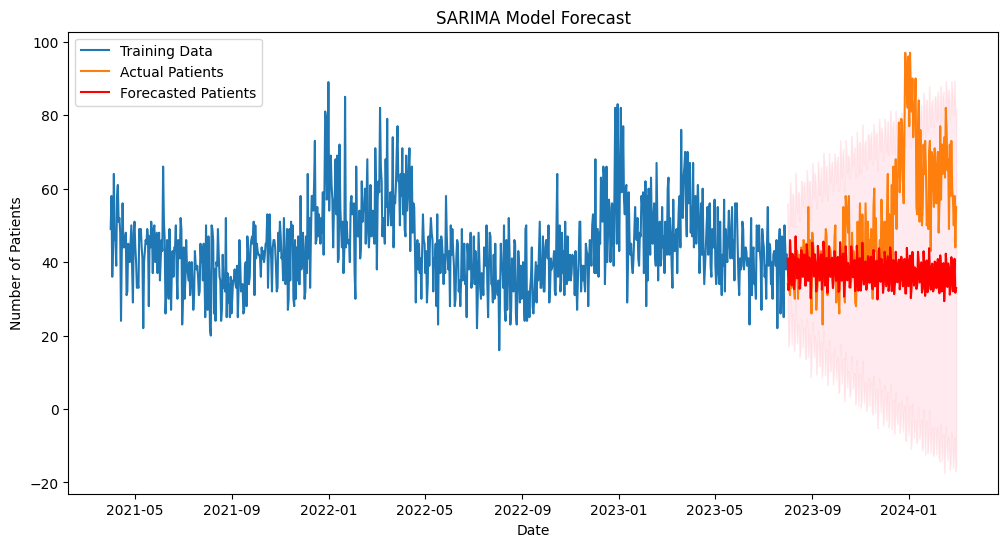

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fit the SARIMA model
sarima_model = SARIMAX(train['Number of patients'],
                       order=(6,1,7),
                       seasonal_order=(0,1,1,12))
sarima_model_fit = sarima_model.fit()

# Forecast the number of patients
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test))
forecast_index = test.index
forecast_mean = sarima_forecast.predicted_mean
forecast_ci = sarima_forecast.conf_int()

# Calculate error statistics
sarima_me = (test['Number of patients'] - forecast_mean).mean()
sarima_mae = mean_absolute_error(test['Number of patients'], forecast_mean)
sarima_mse = mean_squared_error(test['Number of patients'], forecast_mean)
sarima_rmse = sarima_mse**0.5
sarima_mape = np.mean(np.abs((test['Number of patients'] - forecast_mean) / test['Number of patients'])) * 100
sarima_aic = sarima_model_fit.aic
sarima_bic = sarima_model_fit.bic

# Print error statistics
print('The Error Statistics of the SARIMA Forecast Model are:')
print(f'Mean Error (ME): {sarima_me}')
print(f'Mean Absolute Error (MAE): {sarima_mae}')
print(f'Mean Squared Error (MSE): {sarima_mse}')
print(f'Root Mean Squared Error (RMSE): {sarima_rmse}')
print(f'AIC: {sarima_aic}')
print(f'BIC: {sarima_bic}')
print(f'Mean Absolute Percentage Error (MAPE) for SARIMA: {sarima_mape}%')

# Plot the forecast against actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Number of patients'], label='Training Data')
plt.plot(test.index, test['Number of patients'], label='Actual Patients')
plt.plot(forecast_index, forecast_mean, label='Forecasted Patients', color='red')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

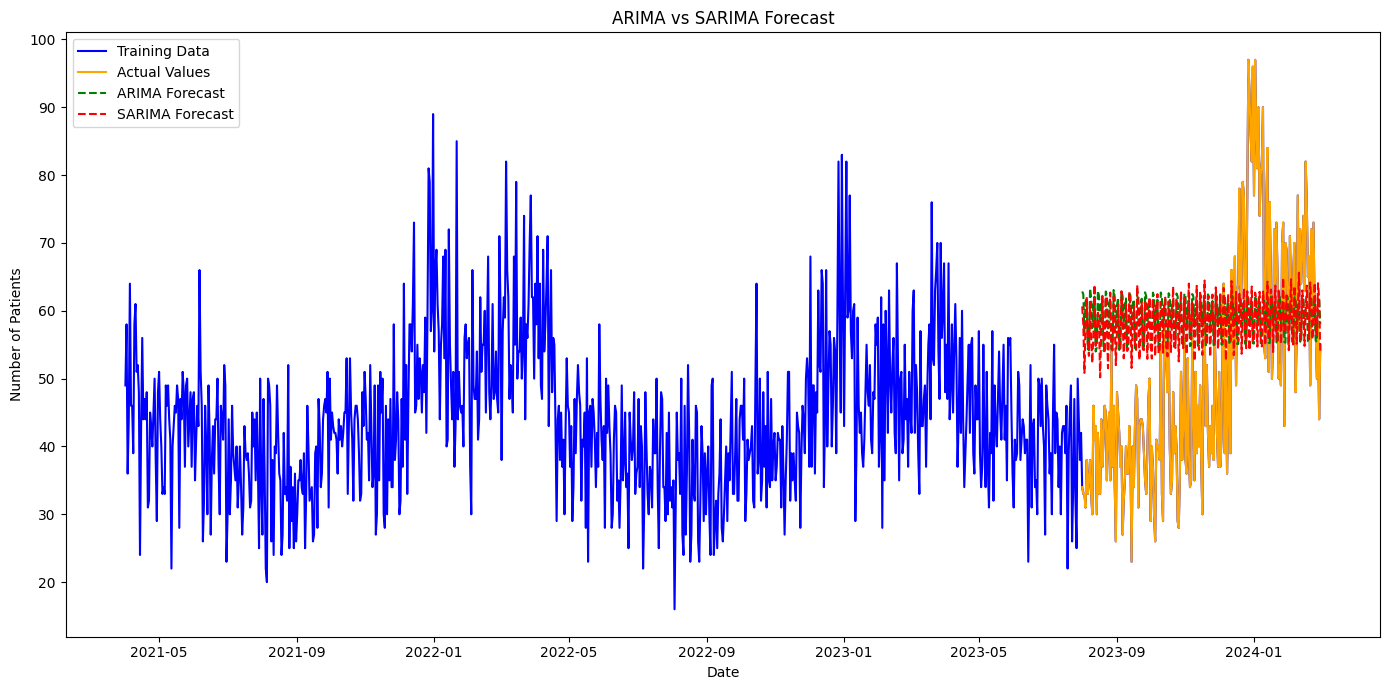

ARIMA RMSE: 18.45979832894026, ARIMA MAPE: nan%
SARIMA RMSE: 17.40990328918759, SARIMA MAPE: nan%


In [ ]:
# Fit ARIMA model
arima_model = ARIMA(train['Number of patients'], order=(6, 1, 7))
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.forecast(steps=len(test))
arima_mse = mean_squared_error(test['Number of patients'], arima_forecast)
arima_rmse = np.sqrt(arima_mse)
arima_mape = np.mean(np.abs((test['Number of patients'] - arima_forecast) / test['Number of patients'])) * 100

# Fit SARIMA model
sarima_model = SARIMAX(train['Number of patients'], order=(6, 1, 7), seasonal_order=(0, 1, 1, 12))
sarima_model_fit = sarima_model.fit()
sarima_forecast = sarima_model_fit.forecast(steps=len(test))
sarima_mse = mean_squared_error(test['Number of patients'], sarima_forecast)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mape = np.mean(np.abs((test['Number of patients'] - sarima_forecast) / test['Number of patients'])) * 100

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Number of patients'], label='Training Data', color='blue')
plt.plot(test.index, test['Number of patients'], label='Actual Values', color='orange')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='green')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', linestyle='--', color='red')
plt.title('ARIMA vs SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Print error statistics
print(f'ARIMA RMSE: {arima_rmse}, ARIMA MAPE: {arima_mape}%')
print(f'SARIMA RMSE: {sarima_rmse}, SARIMA MAPE: {sarima_mape}%')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


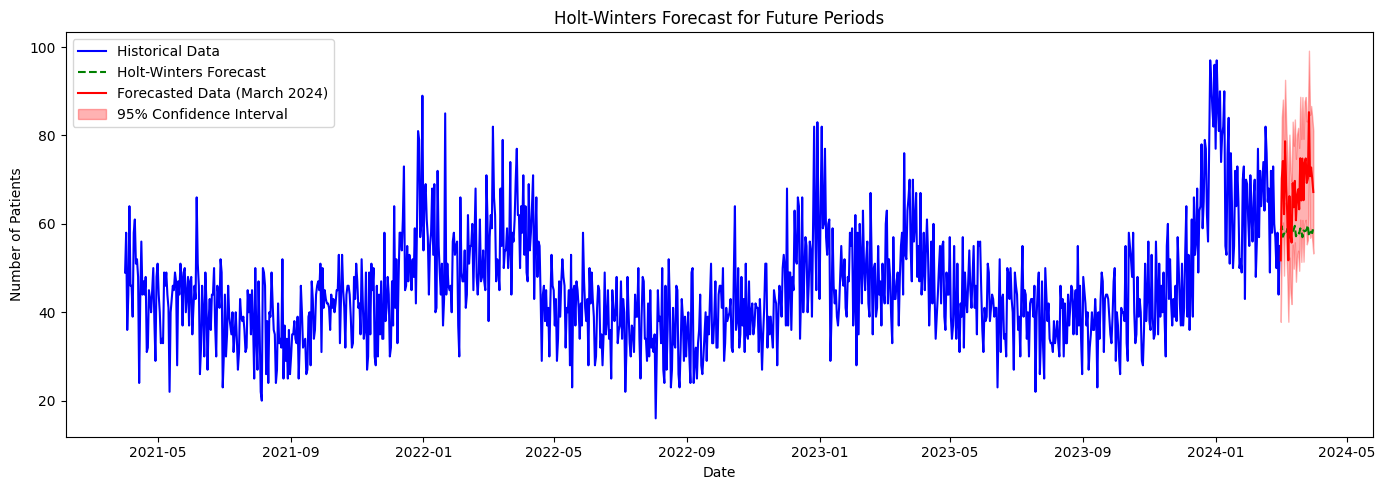

Future Forecasted Values:
2024-03-01    58.647579
2024-03-02    59.466104
2024-03-03    57.089733
2024-03-04    57.762838
2024-03-05    58.025253
2024-03-06    57.719488
2024-03-07    58.882017
2024-03-08    58.274978
2024-03-09    56.886106
2024-03-10    58.405319
2024-03-11    58.219572
2024-03-12    58.319132
2024-03-13    58.749171
2024-03-14    59.567696
2024-03-15    57.191325
2024-03-16    57.864430
2024-03-17    58.126845
2024-03-18    57.821080
2024-03-19    58.983609
2024-03-20    58.376570
2024-03-21    56.987698
2024-03-22    58.506911
2024-03-23    58.321164
2024-03-24    58.420724
2024-03-25    58.850763
2024-03-26    59.669288
2024-03-27    57.292917
2024-03-28    57.966022
2024-03-29    58.228437
2024-03-30    57.922672
2024-03-31    59.085201
Freq: D, dtype: float64


In [ ]:
# Fit Holt-Winters model on the entire dataset
hw_model = ExponentialSmoothing(train['Number of patients'],
                                seasonal='additive',
                                seasonal_periods=12,
                                trend='additive')
hw_model_fit = hw_model.fit()

# Forecast for future
future_forecast = hw_model_fit.forecast(steps=31)
future_forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1),
                                      periods=number_of_days, freq='D')
# Plot the historical data along with the forecast
plt.figure(figsize=(14, 5))
plt.plot(data.index, data['Number of patients'], label='Historical Data', color='blue')
plt.plot(future_forecast.index, future_forecast, label='Holt-Winters Forecast', linestyle='--', color='green')
plt.plot(future_forecast_df['Forecast'], label='Forecasted Data (March 2024)', color='red')
plt.fill_between(future_forecast_df.index, future_forecast_df['CI Lower'], future_forecast_df['CI Upper'], color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('Holt-Winters Forecast for Future Periods')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Print forecasted values
print("Future Forecasted Values:")
print(future_forecast)


13

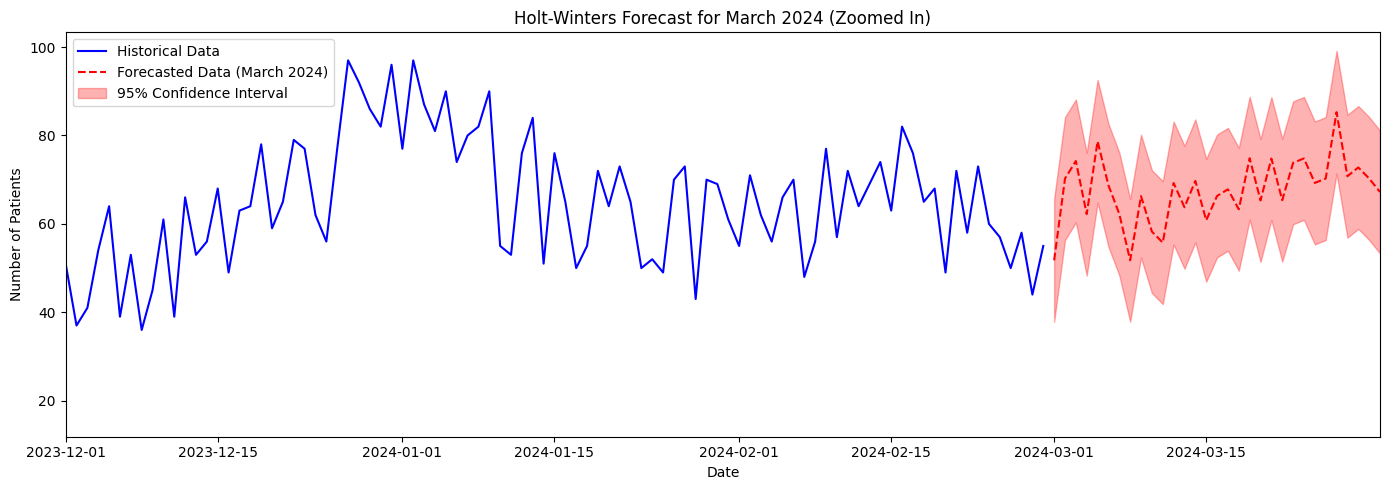

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(data.index, data['Number of patients'], label='Historical Data', color='blue')
plt.plot(future_forecast_df.index, future_forecast_df['Forecast'], label='Forecasted Data (March 2024)', color='red', linestyle='--')
plt.fill_between(future_forecast_df.index, future_forecast_df['CI Lower'], future_forecast_df['CI Upper'], color='red', alpha=0.3, label='95% Confidence Interval')
plt.xlim(['2023-12', '2024-03-31'])
plt.title('Holt-Winters Forecast for March 2024 (Zoomed In)')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.legend(loc='upper left')
plt.tight_layout()
p

In [ ]:
forecast_data = pd.DataFrame({
    'Forecasted Mean': future_forecast_mean
}, index=future_forecast_index)

forecast_data.to_csv('Future Forecast Values.csv',sep=',')